<a href="https://colab.research.google.com/github/Khalidmamdou7/CMP637-assignments/blob/main/Notebooks/MNIST-autoregressive-models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Note: Don't import any other libraries for deep learning or ML in general.
import math
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# If you wish, you can include other libraries related to side tasks
# such as drawing images, showing a progress bar, etc.
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

## Define utility functions

In [3]:
# Note: If you wish to add or modify some utility functions, feel free to do so.

# You can change this variable to choose between discrete and continuous images
# In the discrete case, the image channels are of type uint8 with values from 0 to 255
# In the continous case, the image channels are of type float with values from 0 to 1
use_discrete_data = False
use_binary_data = True  # two values only {0, 1} or {0, 255}

# Show a batch of images x and their corresponding classes y
# Params:
# - x: A tensor of shape [Batch Size, 1, Height, Width] and type float
# - y: A tensor of shape [Batch Size] and type int64
def show_images(x: torch.Tensor, y: torch.Tensor):
  # Convert images to a color uint8 numpy array
  if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
  else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
  # Calculate the number of rows and columns to organize the images
  count = x.shape[0]
  rows = max(1, int(count ** 0.5))
  columns = max(1, count // rows)
  # Draw a grid or images
  plt.figure(figsize=(columns, rows))
  for i in range(count):
    plt.subplot(rows, columns, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(f"Class: {y[i]}", fontsize=10)
  plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.show()

In [32]:
## Optional TODO: Save the model if you want to store your work on disk and load it later
import torch
from pathlib import Path
from datetime import datetime

def save_checkpoint(
    model,
    optimizer,
    epoch,
    loss=None,
    base_dir="/content/checkpoints",
    prefix="fvsbn"
):
    """
    Saves model + optimizer with timestamp to avoid overwriting.
    """
    base_dir = Path(base_dir)
    base_dir.mkdir(parents=True, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{prefix}_epoch{epoch}_{timestamp}.pt"
    path = base_dir / filename

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
        "timestamp": timestamp
    }, path)

    print(f"Checkpoint saved: {path}")
    return path


def load_checkpoint(
    model,
    optimizer=None,
    path=None,
    device="cpu"
):
    """
    Loads model (and optimizer if provided).
    """
    checkpoint = torch.load(path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer is not None and "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    epoch = checkpoint.get("epoch", 0)
    loss = checkpoint.get("loss", None)

    print(f"Loaded checkpoint from epoch {epoch}")
    return epoch, loss



from google.colab import drive

def mount_gdrive(mount_point="/content/drive"):
    drive.mount(mount_point)
    print("Google Drive mounted")

mount_gdrive()


from pathlib import Path
from datetime import datetime
import torch

def save_checkpoint_gdrive(
    model,
    optimizer,
    epoch,
    loss=None,
    drive_dir="/content/drive/MyDrive/fvsbn_checkpoints",
    prefix="fvsbn"
):
    drive_dir = Path(drive_dir)
    drive_dir.mkdir(parents=True, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{prefix}_epoch{epoch}_{timestamp}.pt"
    path = drive_dir / filename

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
        "timestamp": timestamp
    }, path)

    print(f"Checkpoint saved to Google Drive: {path}")
    return path



def load_checkpoint_gdrive(
    model,
    optimizer=None,
    path=None,
    device="cpu"
):
    checkpoint = torch.load(path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer is not None and "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    epoch = checkpoint.get("epoch", 0)
    loss = checkpoint.get("loss", None)

    print(f"Loaded checkpoint from epoch {epoch}")
    return epoch, loss

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted


## Load and visualize the dataset

In [4]:
# TODO [Optional]: You can modify the transforms.
# Note: If you modify the transforms, you may need to modify the `show_images` function.
if use_discrete_data:
    if use_binary_data:
        transform = transforms.Compose([
            transforms.PILToTensor(),
            transforms.Lambda(lambda x: (x > 127).to(torch.uint8) * 255)
        ])
    else:
        transform = transforms.Compose([
            transforms.PILToTensor(),
        ])
else:
    if use_binary_data:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: (x > 0.5).float())
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])

# This will load the dataset into the folder "datasets" the first time it is run
train_dataset = torchvision.datasets.MNIST(root="datasets", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="datasets", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

dataset = train_dataset

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.92MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.37MB/s]


torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.float32 torch.int64
tensor(0.) tensor(1.)
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
          0., 0., 0., 0., 0.,

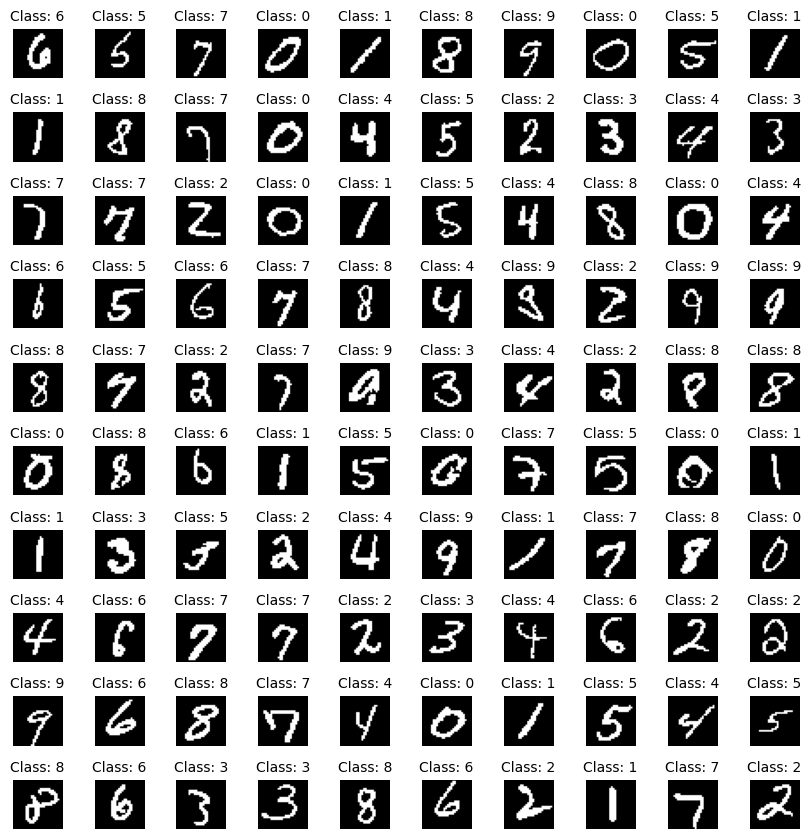

In [5]:
def show_dataset_sample(sample_size: int = 100):
  loader = DataLoader(dataset, batch_size=100, shuffle=True)
  x, y = next(iter(loader))
  print(x.shape, y.shape)
  print(x.dtype, y.dtype)
  print(x.min(), x.max())
  print(x[0])
  print(y[0])
  show_images(x, y)

show_dataset_sample()

## Select a device

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected Device:", device)

Selected Device: cuda


## Define the model

In [22]:
# TODO: Define your model(s) and loss function(s) here.
# You can add as many cells as you like.
# You can add utility functions related to the model here too.

class FVSBN(nn.Module):
    """
    Fully Visible Sigmoid Belief Network
    """
    def __init__(self, l = 28, w = 28):
        super().__init__()
        self.n_pixels = l * w
        # converting the image from 2d to 1d [28, 28] -> [784]
        self.flatten = nn.Flatten(start_dim=1)  # Flatten all dims except batch

        # Create Parameters for each conditional
        # For pixel i, we need i parameters (including bias)
        # Total parameters: 1 + 2 + 3 + ... + n = n(n+1)/2
        weights_scaling_factor = 0.01
        self.params = nn.ParameterList([
            nn.Parameter(torch.randn(i + 1) * weights_scaling_factor) # [bias, alpha_0, alpha_1, .., alpha_i-1]
            for i in range(self.n_pixels)
        ])

        # mask = create_fvsbn_mask(self.n_pixels)
        # self.linear = MaskedLinear( in_features=self.n_pixels, out_features=self.n_pixels, mask=mask )
    def forward(self, x):
        """
        Computes log probability of x
        Args:
            x: [Batch, Channels, Height, Width] [100, 1, 28, 28] with values in [0, 255]
        returns: logits for Bernoulli distribution
        """
        # Handle both flattened and unflattened input
        if x.dim() > 2:
            x = self.flatten(x)  # (batch_size, 1, 28, 28) -> (batch_size, 784)


        batch_size = x.size(0)
        log_prob = torch.zeros(batch_size, device=x.device)


        for i in range(self.n_pixels):
            params = self.params[i].to(x.device)

            if i == 0:
                # First pixel: only bias
                # expand repeats for the whole batches
                logits = params[0].expand(batch_size)
            else:
                # Other pixels
                # Compute: bias + sum(alpha_j * x_j) for j < i
                bias = params[0]
                weights = params[1:]    # shape: (i,)
                x_prev = x[:, :i]       # shape: (batch_size, i)
                logits = bias + torch.sum(weights * x_prev, dim=1)

            # Compute Bernoulli probability
            probs = torch.sigmoid(logits)

            # P(X = x) = p^x * (1-p)^(1-x)
            # Log probability: log p(x_i | x_<i)
            # log P(X = x) = x * log(p) + (1-x) * log(1-p)
            # 1e-8 is for numerical stability to prevent log(0) = -inf
            log_prob += x[:, i] * torch.log(probs + 1e-8) + \
                (1 - x[:, i]) * torch.log(1 - probs + 1e-8)

        return log_prob
        # logits = self.linear(x)
        # return logits

    def sample(self, n_samples=1, device='cpu'):
        """Returns samples in {0, 255}"""
        samples = torch.zeros(n_samples, self.n_pixels, device=device)
        for i in range(self.n_pixels):
            params = self.params[i].to(device)

            if i == 0:
                # First pixel: only bias
                # expand repeats for the whole batches
                logits = params[0].expand(n_samples)
            else:
                # Other pixels
                bias = params[0]
                weights = params[1:]
                x_prev = samples[:, :i]
                logits = bias + torch.sum(weights * x_prev, dim=1)

            probs = torch.sigmoid(logits)
            samples[:, i] = torch.bernoulli(probs) * 255

        return samples

# class MaskedLinear(nn.Linear):
#     def __init__(self, in_features, out_features, mask):
#         super().__init__(in_features, out_features)
#         self.register_buffer("mask", mask)
#     def forward(self, x):
#         return F.linear(x, self.weight * self.mask, self.bias)

# def create_fvsbn_mask(n):
#     """
#     Creates a strictly lower-triangular mask.
#     Shape: [n, n]
#     """
#     return torch.tril(torch.ones(n, n), diagonal=-1)




def fvsbn_loss(logits, x):
    """
    logits: [B, 784]
    x:      [B, 784]
    """
    return F.binary_cross_entropy_with_logits(
        logits, x, reduction="sum"
    ) / x.size(0)




## Define Hyperparameters

In [30]:
# TODO: Define the hyperparameters here.
batch_size = 100
learning_rate = 1e-3
num_epochs = 1

## Instantiate models and optimizers

In [31]:
# TODO: Instantiate the models and optimizers here.
print(device)
model = FVSBN(l = 28, w = 28).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda


## Train the model

In [33]:
# TODO: Write the code to train the model here

# checkpoint_path = "/content/checkpoints/fvsbn_epoch4_20251224_143015.pt"

# start_epoch, last_loss = load_checkpoint(
#     model=model,
#     optimizer=optimizer,
#     path=checkpoint_path,
#     device=device
# )

# for epoch in range(start_epoch + 1, num_epochs):
#     ...

train_losses = []


model.train()

for epoch in range(num_epochs):
    for batch_idx, (x, _) in enumerate(train_loader):

        optimizer.zero_grad()

        log_prob = model(x)

        # Negative log likelihood loss (maximize log prob)
        loss = -log_prob.mean()

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}: loss = {loss.item():.4f}")

    # save after each epoch
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch,
        loss=loss.item()
    )


Epoch 0, Batch 0: loss = 543.8990
Epoch 0, Batch 100: loss = 290.6569
Epoch 0, Batch 200: loss = 250.2182
Epoch 0, Batch 300: loss = 235.7170
Epoch 0, Batch 400: loss = 222.2934
Epoch 0, Batch 500: loss = 203.3950
Checkpoint saved: /content/checkpoints/fvsbn_epoch0_20251224_150610.pt


## [Optional] Save and/or load the model

In [ ]:
save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch,
        loss=loss.item()
    )

## Write the generation function

In [34]:
# TODO: Rewrite the following function

# Given a tensor of classes y, this function conditionally generates a tensor images.
# Params:
# - y: A tensor of shape [Batch Size] and type int64 and resides on the CPU memory
# Return: A tensor of shape [Batch Size, 1, Height, Width] and type float32
def generate(y: torch.Tensor) -> torch.Tensor:
    model.eval()
    with torch.no_grad():
        batch_size = y.shape[0]
        samples = model.sample(batch_size, device=device)
        samples = samples.view(batch_size, 1, 28, 28)
        return samples
#   return torch.zeros((batch_size, 1, 28, 28), dtype=torch.float32)

## Generate some images and display them

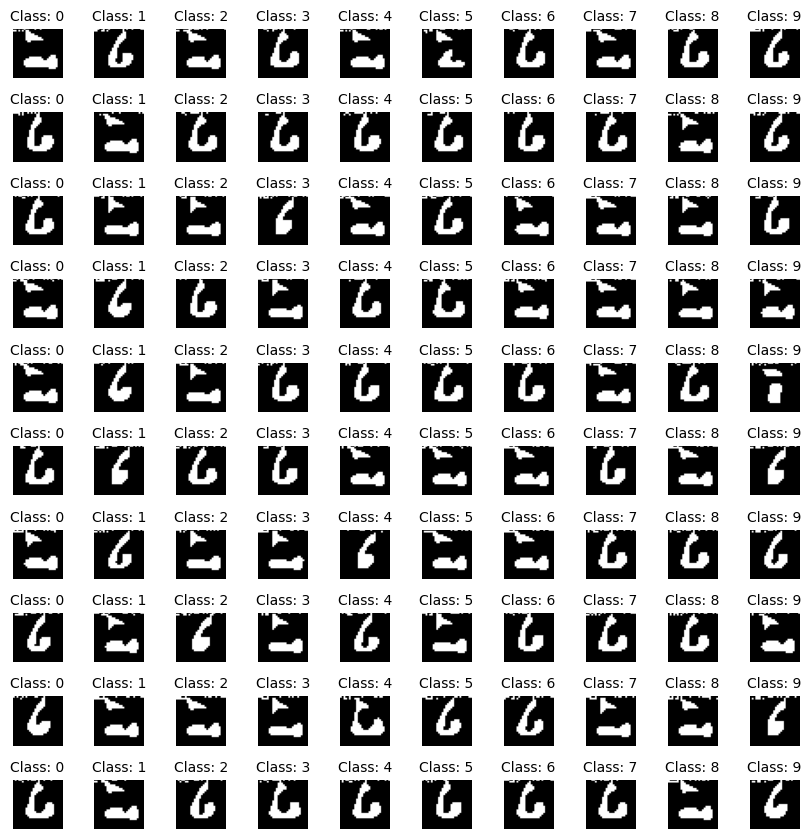

In [35]:
# Generate 100 images (10 images per class x 10 classes)
y = torch.tensor([i for _ in range(10) for i in range(10)], dtype=torch.long)
x = generate(y)
show_images(x, y)

## [Optional] Extras

You can do any extra stuff you want here. Some examples are:
* Draw a graph of the loss functions.
* Implement interpolation in latent space (You can try it with Normalizing flows, Latent variable models and Implicit models).
* Implement image in-painting (You can try it with Score-based models, and in a limited form with Autoregressive models too).
* Visualize the generation process (You can try it with Energy-based and Score-based models).

### Loss Function graph

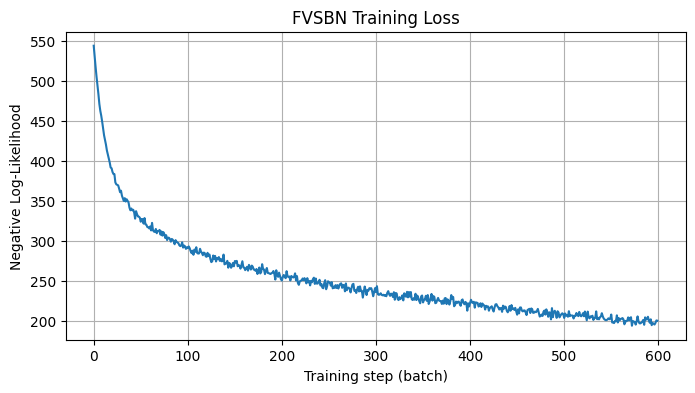

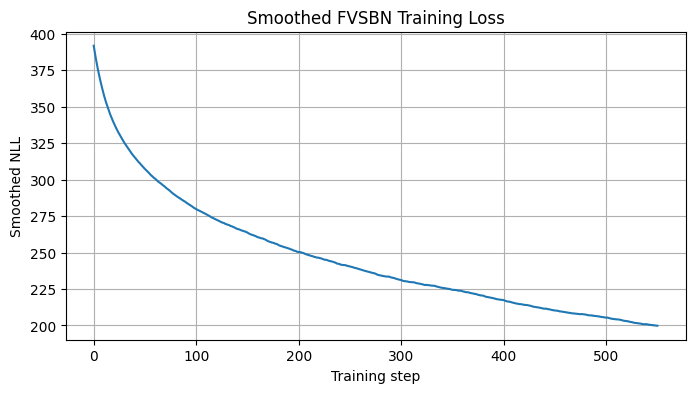

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(train_losses)
plt.xlabel("Training step (batch)")
plt.ylabel("Negative Log-Likelihood")
plt.title("FVSBN Training Loss")
plt.grid(True)
plt.show()


import numpy as np

def moving_average(x, window=50):
    return np.convolve(x, np.ones(window)/window, mode="valid")

plt.figure(figsize=(8, 4))
plt.plot(moving_average(train_losses, 50))
plt.xlabel("Training step")
plt.ylabel("Smoothed NLL")
plt.title("Smoothed FVSBN Training Loss")
plt.grid(True)
plt.show()

